### Google Cloud Storage in Zarr format : Benchmark

In [1]:
import numpy as np
from contextlib import contextmanager
import intake
import time
#import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import s3fs
import xarray as xr
import dask
import fsspec
import zarr
import dask.array as dsa
import pandas as pd

endpoint_url = "https://mghp.osn.xsede.org"
bucket = 'cnh-bucket-1'


In [3]:
fs = s3fs.S3FileSystem(anon=True,
                       client_kwargs={'endpoint_url': endpoint_url})
listing = fs.listdir(bucket)
listing

[{'Key': 'cnh-bucket-1/DYAMOND',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/DYAMOND'},
 {'Key': 'cnh-bucket-1/llc4320_grid',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc4320_grid'},
 {'Key': 'cnh-bucket-1/llc4320_tests',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc4320_tests'},
 {'Key': 'cnh-bucket-1/llc4320_zarr',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc4320_zarr'},
 {'Key': 'cnh-bucket-1/llc_masks',
  'Size': 0,
  'StorageClass': 'DIRECTORY',
  'type': 'directory',
  'size': 0,
  'name': 'cnh-bucket-1/llc_masks'}]

In [4]:
path = 'cnh-bucket-1/llc4320_tests/10dayhourly'
listing = fs.listdir(path)
len(listing)

4820

In [5]:
listing[0]

{'Key': 'cnh-bucket-1/llc4320_tests/10dayhourly/Eta.0000787968.data.shrunk',
 'LastModified': datetime.datetime(2021, 2, 21, 17, 42, 18, 455000, tzinfo=tzlocal()),
 'ETag': '"adf92d9b6f0541212177052e2cd56974-108"',
 'Size': 562551864,
 'StorageClass': 'STANDARD',
 'type': 'file',
 'size': 562551864,
 'name': 'cnh-bucket-1/llc4320_tests/10dayhourly/Eta.0000787968.data.shrunk'}

In [6]:
nbytes_compressed = listing[0]['Size']
print(f'Compressed size: {nbytes_compressed/1e6} MB')

Compressed size: 562.551864 MB


In [7]:
gcs_url = 'pangeo-ecco-llc4320/ssh'
fs_gcs = fsspec.get_filesystem_class('gs')(requester_pays=True)
gcs_mapper = fs_gcs.get_mapper(gcs_url)

In [8]:
zgroup = zarr.open_consolidated(gcs_mapper)
print(zgroup.info)

Name             : /
Type             : zarr.hierarchy.Group
Read-only        : False
Store type       : zarr.storage.ConsolidatedMetadataStore
Chunk store type : fsspec.mapping.FSMap
No. members      : 5
No. arrays       : 5
No. groups       : 0
Arrays           : Eta, face, i, j, time



In [9]:
array = zgroup['Eta']

In [10]:
%time _ = array[0, :3]

CPU times: user 833 ms, sys: 364 ms, total: 1.2 s
Wall time: 1.1 s


In [11]:
%time _ = array[0]

CPU times: user 3.64 s, sys: 1.68 s, total: 5.33 s
Wall time: 3.56 s


In [12]:
array_dask = dask.array.from_zarr(array)
array_dask

,Array,Chunk
Bytes,8.76 TB,74.65 MB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,>f4,numpy.ndarray


In [13]:
%time _ = array_dask[0].compute()

CPU times: user 3.36 s, sys: 1.65 s, total: 5.01 s
Wall time: 2.99 s


In [14]:
data = array_dask[0]
data

dask.array<getitem, shape=(13, 4320, 4320), dtype=>f4, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>

### Setting up Benchmarking

In [15]:
class DevNullStore:

    def __init__(self):
        pass

    def __setitem__(*args, **kwargs):
        pass

In [16]:
null_store = DevNullStore()
# this line produces no error but actually does nothing
null_store['foo'] = 'bar'

In [17]:
%time dsa.store(data, null_store, lock=False)

CPU times: user 3.26 s, sys: 1.31 s, total: 4.57 s
Wall time: 2.84 s


In [18]:
from dask_gateway import Gateway
from dask.distributed import Client

gateway = Gateway()
cluster = gateway.new_cluster()
cluster

In [19]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7bf6b7eec30a4402a443ddfcd822cec4 Dashboard: /services/dask-gateway/clusters/prod.7bf6b7eec30a4402a443ddfcd822cec4/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [20]:
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

diag_timer = DiagnosticTimer()


In [21]:
chunksize = np.prod(data.chunksize) * data.dtype.itemsize
chunksize

74649600

In [22]:
def total_nthreads():
    return sum([v for v in client.nthreads().values()])

def total_ncores():
    return sum([v for v in client.ncores().values()])

def total_workers():
    return len(client.ncores())

### Running the tests

In [23]:
diag_kwargs = dict(nbytes=data.nbytes, chunksize=chunksize,
                   cloud='GCS', format='zarr')

#1,1,2,2,4,4,6,7,8,9,15,16
for nworkers in [20,25,30,35,40,45,50,55,60,70]:
    cluster.scale(nworkers)
    time.sleep(10)
    client.wait_for_workers(nworkers)
    print(nworkers)
    with diag_timer.time(nthreads=total_nthreads(),
                         ncores=total_ncores(),
                         nworkers=total_workers(),
                         **diag_kwargs):

        future = dsa.store(data, null_store, lock=False, compute=False)
        dask.compute(future, retries=5)



20
25
30
35
40
45
50
55
60
70


In [24]:
client.close()
cluster.close()

### Looking at results and saving files

In [25]:
df = diag_timer.dataframe()
df

,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime
0,40,40,20,970444800,74649600,GCS,zarr,7.277597
1,50,50,25,970444800,74649600,GCS,zarr,6.239417
2,60,60,30,970444800,74649600,GCS,zarr,3.664774
3,70,70,35,970444800,74649600,GCS,zarr,3.600762
4,80,80,40,970444800,74649600,GCS,zarr,0.874773
5,90,90,45,970444800,74649600,GCS,zarr,3.681961
6,100,100,50,970444800,74649600,GCS,zarr,3.853706
7,110,110,55,970444800,74649600,GCS,zarr,0.797578
8,120,120,60,970444800,74649600,GCS,zarr,3.566920
9,140,140,70,970444800,74649600,GCS,zarr,3.585861


<AxesSubplot:xlabel='ncores'>

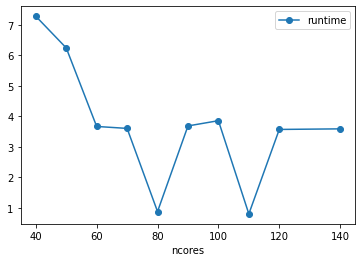

In [26]:
df.plot(x='ncores', y='runtime', marker='o')

<AxesSubplot:xlabel='ncores'>

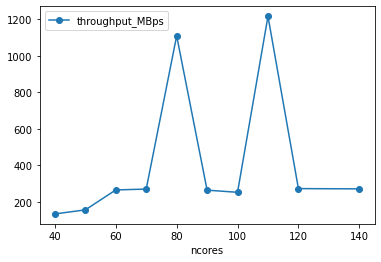

In [27]:
df['throughput_MBps'] = df.nbytes / 1e6 / df['runtime']
df.plot(x='ncores', y='throughput_MBps', marker='o')

<AxesSubplot:xlabel='nthreads'>

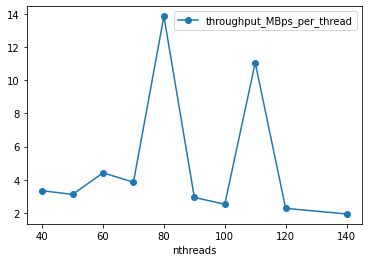

In [28]:
df['throughput_MBps_per_thread'] = df.throughput_MBps / df.nthreads
df.plot(x='nthreads', y='throughput_MBps_per_thread', marker='o')

In [29]:
df.to_csv('gcs_zarr_test-3_us_central.csv')

In [30]:
df

,nthreads,ncores,nworkers,nbytes,chunksize,cloud,format,runtime,throughput_MBps,throughput_MBps_per_thread
0,40,40,20,970444800,74649600,GCS,zarr,7.277597,133.346869,3.333672
1,50,50,25,970444800,74649600,GCS,zarr,6.239417,155.534536,3.110691
2,60,60,30,970444800,74649600,GCS,zarr,3.664774,264.803420,4.413390
3,70,70,35,970444800,74649600,GCS,zarr,3.600762,269.510926,3.850156
4,80,80,40,970444800,74649600,GCS,zarr,0.874773,1109.367238,13.867090
5,90,90,45,970444800,74649600,GCS,zarr,3.681961,263.567389,2.928527
6,100,100,50,970444800,74649600,GCS,zarr,3.853706,251.821174,2.518212
7,110,110,55,970444800,74649600,GCS,zarr,0.797578,1216.739169,11.061265
8,120,120,60,970444800,74649600,GCS,zarr,3.566920,272.068036,2.267234
9,140,140,70,970444800,74649600,GCS,zarr,3.585861,270.630887,1.933078
